# One-zone X-ray burst

This is a simple one-zone model of a pure He [X-ray burst](https://en.wikipedia.org/wiki/X-ray_burster).  It follows [Heger, Cumming, & Woosley 2007](https://iopscience.iop.org/article/10.1086/517491) (HCW07), but we consider the accretion to be pure He to simplify the model.

We solve evolution equations for temperature, $T$, and column depth, $y$:

$$
\frac{dT}{dt} = \frac{1}{c_p} \left ( \epsilon_{3\alpha} + Q_\mathrm{crust} \frac{\dot{m}}{y} \right ) - \epsilon_\mathrm{cool}
$$

$$\frac{dy}{dt} = \dot{m} - \frac{\epsilon_{3\alpha}}{Q_{3\alpha}} y$$

where $\epsilon_{3\alpha}$ is the energy generation rate (erg/g/s) for the 3-$\alpha$ reaction,
$Q_{3\alpha}$ is the energy / gram released in burning, $Q_\mathrm{crust}$ is the crustal heating
energy (erg/g), and $\dot{m}$ is the accretion rate.  The cooling term is the outward radiative energy flux,

$$\epsilon_\mathrm{cool} \approx \frac{F_\gamma}{y} = \frac{acT^4}{3\kappa y^2}$$

The first equation is essentially the first law of thermodynamics, and simply says that the energy increases in the zone due to heat release ($\epsilon_{3\alpha}$ and $Q_\mathrm{crust}$) and decreases due to radiation cooling our zone.

The second equation is conservation of mass.  Here column depth is:

$$y = \int_{z = 0}^{z = -z_\mathrm{base}} \rho dz$$

where $z_\mathrm{base}$ is the physical depth of the fuel layer.  So $y$ is measuring the mass of the fuel (He in our case) in a column on the surface of the neutron star.  We see that it increases due to accretion of new fuel ($\dot{m}$) and decreases as fuel is burned ($-\epsilon_{3\alpha} y / Q_\mathrm{3\alpha}$).

At any column depth, $y$, we know the pressure from:

$$p = |g|y$$

and then from the equation of state, we can get the density.

## Equation of state

We'll assume an equation of state consisting of ideal gas ions / nuclei:

  $$P_\mathrm{ion} = \frac{\rho k_B T}{\mu_I m_u}$$

and electrons that can be ideal or non-relativisitic degenerate.
The degenerate limit has:

  $$P_{e,\mathrm{deg}} = \frac{h^2}{20 m_e} \left ( \frac{3}{\pi} \right )^{2/3} \left ( \frac{\rho}{\mu_e m_u} \right )^{5/3}$$

while the ideal gas limit has:

  $$P_\mathrm{e,\mathrm{ideal}} = \frac{\rho k_B T}{\mu_e m_u}$$

A common approximation is to blend this limits as:

$$P_e = \sqrt{P_{e,\mathrm{deg}}^2 + P_{e,\mathrm{ideal}}^2}$$

We also need the specific heat at constant pressure.  We'll
consider only the ions and take:

$$c_p = \frac{5}{2} \frac{k_B}{\mu_I m_u}$$

## Nuclear energy generation

The energy generation comes from triple alpha.
The triple alpha rate is:

$$q_{3\alpha} = 5.09\times 10^{11} \rho^2 Y^3 T_8^{-3} e^{-44.027/T8}~\mathrm{erg/g/s}$$

where $T_8 = T / (10^8~\mathrm{K})$.

The energy release from 3-alpha is 7.275 MeV or 0.606 MeV / nucleon.

## Eddington limit

For a spherical accretor, the Eddington luminosity is:

$$L_\mathrm{Edd} = \frac{4\pi Gc M}{\kappa}$$

and if we look at the accretion luminosity:

$$L_\mathrm{acc} = \frac{G M \dot{M}}{R}$$

we can define the Eddington accretion rate:

$$\dot{M}_\mathrm{Edd} = \frac{4\pi c R}{\kappa}$$

we want the column accretion rate, so we divide this by the surface area:

$$\dot{m}_\mathrm{Edd} = \frac{\dot{M}_\mathrm{Edd}}{4\pi R^2} = \frac{c}{\kappa R}$$

We'll use this as a reference value for the $\dot{m}$ we need
to specify in our problem.

## Simplifications

Compared to HCW07, we make the following simplifications:

* We accrete pure He, so there is no hot-CNO term in the energy generation
* We don't modify the energy generation to account for burning to Fe-group
* We ignore radiation in the pressure, and our specific heat only includes ions
* Our opacity is simple constant electron scattering --- we don't worry about T-dependence

Additionally, we find that the crustal heating term is important.

## Implementation

In [1]:
import numpy as np
from scipy.optimize import brentq
from scipy.integrate import solve_ivp

In [2]:
class XRB:
    """assuming pure He bursts"""
    def __init__(self, mdot=1.0, y_0=1.e8, T_0=2.e8,
                 g=1.9e14, R=1.e6):
        self.mdot = mdot
        self.y_0 = y_0
        self.T_0 = T_0
        self.g = g
        self.R = R
               
        # mean molecular weights
        self.mu_I = 4.0
        self.mu_e = 2.0

        # constants
        self.k_B = 1.38e-16  # erg / K
        self.h = 6.67e-27  # erg s
        self.m_e = 9.11e-28  # g
        self.m_u = 1.66e-24  # g
        self.c = 3.e10  # cm/s
        self.a = 7.56e-15  # erg / cm**3 / K

        # electron degeneracy
        self.K = self.h**2 /(20 * self.m_e) * (3.0 / np.pi)**(2./3.) * self.m_u**(-5./3.)

        # convert the accretion rate to CGS
        mdot_edd = self.c / self.opacity() / self.R
        self.mdot *= mdot_edd

        # energy release / g from 3-alpha
        erg_per_MeV = 1.6e-6
        
        self.Q_3a = 7.275 / 12 * erg_per_MeV / self.m_u

        # crustal heating
        self.Q_crust = 0.15  # MeV / nucleon
        self.Q_crust *= erg_per_MeV / self.m_u
        
    def rho_from_p(self, p, T):
        
        # ions are ideal gas
        p_ion = lambda rho : rho * self.k_B * T / (self.mu_I * self.m_u)

        # electrons can be ideal gas or degenerate -- we use an approximation to blend
        # the two regimes
        p_e_ideal = lambda rho: rho * self.k_B * T / (self.mu_e * self.m_u)
        p_e_deg = lambda rho: self.K * (rho / self.mu_e)**(5./3.)
        p_e = lambda rho: np.sqrt(p_e_ideal(rho)**2 + p_e_deg(rho)**2)

        # root find on p to get necessary rho
        return brentq(lambda rho: p_ion(rho) + p_e(rho) - p, 1.e2, 1.e8)

    def c_p(self, rho, T):
        """specific heat -- we assume ions are all that matters"""
        c_p_ions = 2.5 * self.k_B / (self.mu_I * self.m_u)      
        return c_p_ions

    def opacity(self):
        """electron scattering (no H)"""
        return 0.2

    def energy_generation(self, rho, T):
        T8 = T / 1.e8
        return 5.09e11 * rho**2 / T8**3 * np.exp(-44.027 / T8)

    def rhs(self, t, state):
        T, y = state

        # pressure comes just from plane-parallel approximation
        p = self.g * y

        # find the corresponding density
        rho = self.rho_from_p(p, T)

        # now compute the microphysics
        kappa = self.opacity()
        c_p = self.c_p(rho, T)
        eps = self.energy_generation(rho, T)

        # compute the outward (cooling) flux
        F = self.a * self.c * T**4 / (3.0 * kappa * y)

        dTdt = (1.0 / c_p) * (eps + self.Q_crust * self.mdot / y - F / y)
        dydt = self.mdot - eps / self.Q_3a * y

        return np.array([dTdt, dydt])

    def evolve(self, tmax):
        sol = solve_ivp(self.rhs, [0, tmax], [self.T_0, self.y_0], method="BDF", rtol=1.e-8)
        return sol

## Exploring solutions

Let's create a burst with the default settings and evolve it for an hour

In [3]:
b = XRB()
sol = b.evolve(3600)

In [4]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'T (K)')

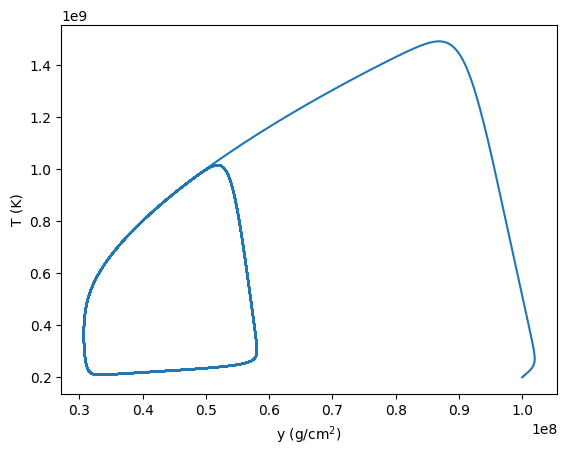

In [5]:
fig, ax = plt.subplots()
ax.plot(sol.y[1,:], sol.y[0,:])
ax.set_xlabel("y (g/cm$^2$)")
ax.set_ylabel("T (K)")

Text(0, 0.5, 'T (K)')

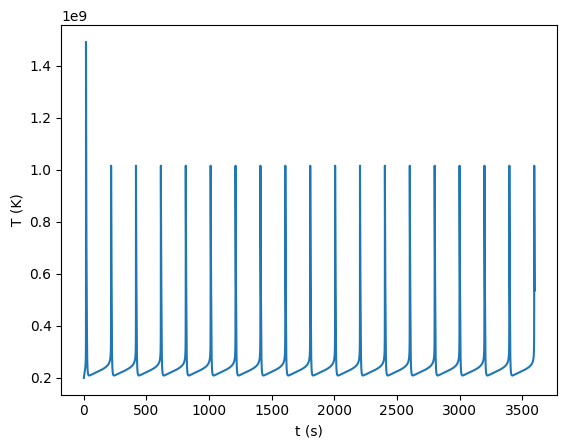

In [6]:
fig, ax = plt.subplots()
ax.plot(sol.t, sol.y[0,:])
ax.set_xlabel("t (s)")
ax.set_ylabel("T (K)")

Text(0, 0.5, 'y (g/cm$^2$)')

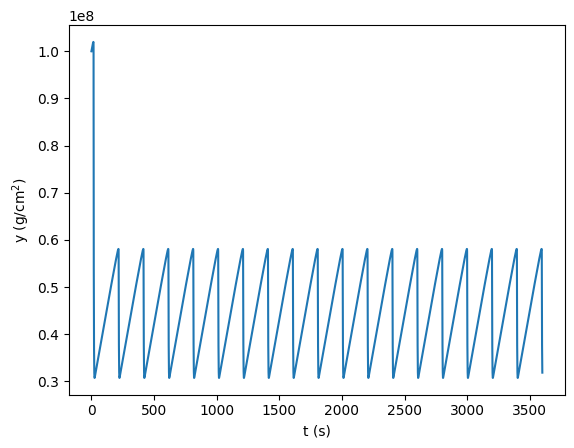

In [7]:
fig, ax = plt.subplots()
ax.plot(sol.t, sol.y[1,:])
ax.set_xlabel("t (s)")
ax.set_ylabel("y (g/cm$^2$)")